## Carregamento

In [2]:
# Importações necessárias
import pandas as pd

# Função para carregar os dados
def carregar_dados(caminho_arquivo, coluna_data=None):
    """
    Carrega um arquivo CSV com dados.
    
    Parâmetros:
    - caminho_arquivo (str): Caminho do arquivo CSV.
    - coluna_data (str, opcional): Nome da coluna de datas para converter para datetime.
    
    Retorna:
    - pandas.DataFrame: DataFrame com os dados carregados.
    """
    # Carrega o CSV
    dados = pd.read_csv(caminho_arquivo)
    
    # Converte a coluna de datas para datetime com timezone, se especificada
    if coluna_data:
        dados[coluna_data] = pd.to_datetime(dados[coluna_data], utc=True)
    
    return dados

# Exemplo de uso da função com coluna de datas 'date'
caminho_arquivo = '../data/processed/AMZN_1997-05-15_2025-02-21_atualizado.csv'
dados = carregar_dados(caminho_arquivo, coluna_data='date')

# Exibir as primeiras linhas do DataFrame
dados.head()

,date,open,high,low,close,adj_close,volume
0,1997-05-15 04:00:00+00:00,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16 04:00:00+00:00,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19 04:00:00+00:00,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20 04:00:00+00:00,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21 04:00:00+00:00,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


## Colunas/descrições

In [1]:
# Dicionário com a descrição de cada coluna do DataFrame 'dados'
colunas_descricao = {
    'date': 'Data do registro',
    'open': 'Preço de abertura',
    'close': 'Preço de fechamento',
    'high': 'Maior preço do dia',
    'low': 'Menor preço do dia',
    'adj_close': 'Preço de fechamento ajustado',
    'volume': 'Volume de ações negociadas'
}

# Gerar o relatório amigável
relatorio = "\n".join([f"{coluna}: {descricao}" for coluna, descricao in colunas_descricao.items()])
print(relatorio)

date: Data do registro
open: Preço de abertura
close: Preço de fechamento
high: Maior preço do dia
low: Menor preço do dia
adj_close: Preço de fechamento ajustado
volume: Volume de ações negociadas


## Tendência de Preço Ajustado ao Longo do Tempo

### Há tendências de alta, baixa ou sazonalidade ao longo do tempo?

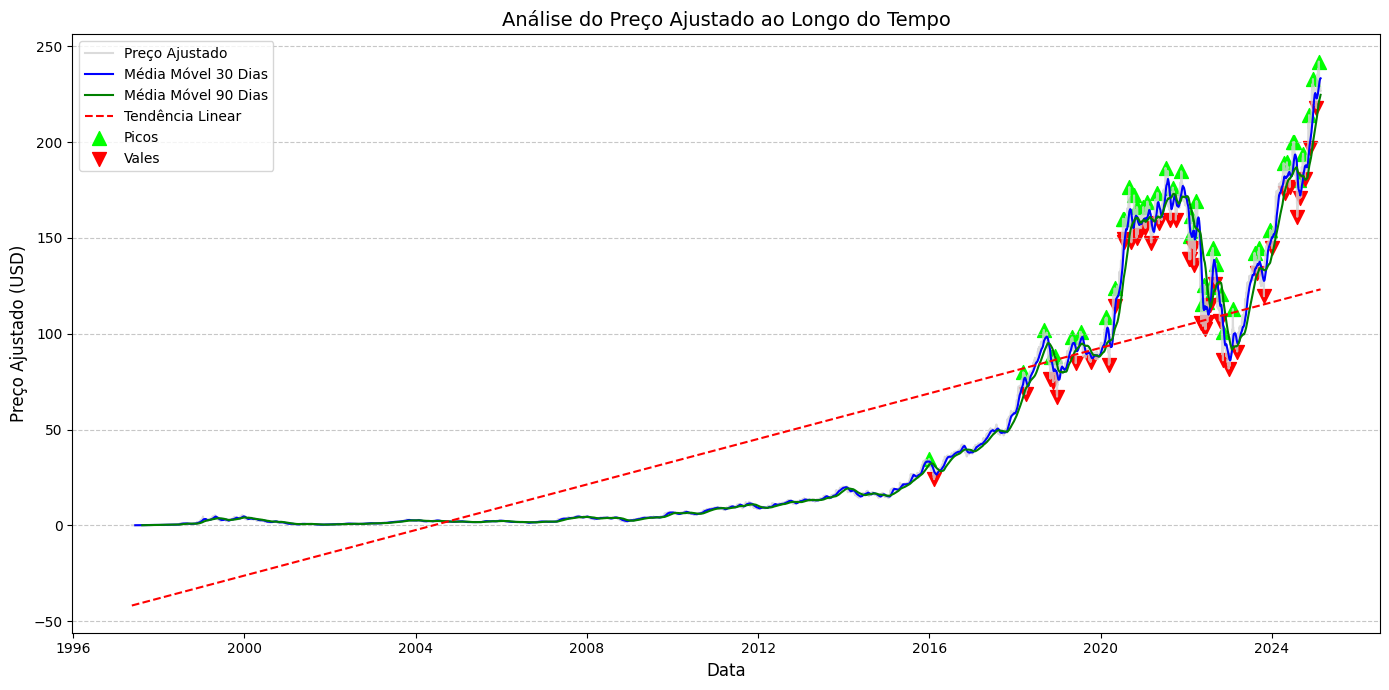


**Insights Estratégicos para Negócios**
1. **Tendência de Longo Prazo**: O preço ajustado mostra uma tendência de alta 📈, 
   com valorização média de **$0.02 por dia**.

2. **Sazonalidade**: Nenhum padrão sazonal claro identificado ⏳.

3. **Pontos Críticos**: 45 picos e 43 vales identificados.
   - Último pico relevante: 05/02/2025
   - Último vale relevante: 15/01/2025

**Recomendações de Ação**:
- 🔍 Monitorar estratégias de compra nos próximos vales identificados.
- 💼 Considerar diversificação se a volatilidade se mantiver alta.
- 📊 Usar médias móveis como indicadores de entrada/saída.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from statsmodels.tsa.seasonal import STL
from sklearn.linear_model import LinearRegression

def load_data(file_path: str) -> pd.DataFrame:
    """Carrega dados de um arquivo CSV ou Excel e prepara o DataFrame."""
    try:
        if file_path.endswith('.csv'):
            df = pd.read_csv(file_path, parse_dates=['date'])
        elif file_path.endswith(('.xls', '.xlsx')):
            df = pd.read_excel(file_path, parse_dates=['date'])
        else:
            raise ValueError("Formato não suportado. Use CSV ou Excel.")
        df = df[['date', 'adj_close']].sort_values('date').set_index('date')
        return df
    except Exception as e:
        print(f"Erro ao carregar dados: {e}")
        return None

def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    """Trata dados ausentes e garante a integridade temporal."""
    df = df.asfreq('D', method='ffill')  # Preenche datas faltantes
    df['adj_close'] = df['adj_close'].interpolate()  # Interpola valores ausentes
    return df

def analyze_trends(df: pd.DataFrame) -> tuple:
    """Calcula médias móveis, tendência linear e retorna coeficientes."""
    df['ma_30'] = df['adj_close'].rolling(30).mean()
    df['ma_90'] = df['adj_close'].rolling(90).mean()
    X = np.arange(len(df)).reshape(-1, 1)
    y = df['adj_close'].values
    model = LinearRegression().fit(X, y)
    df['trend_line'] = model.predict(X)
    return df, model.coef_[0]

def analyze_seasonality(df: pd.DataFrame, period: int = 365) -> tuple:
    """Decompõe a série temporal em componentes sazonais e residuais."""
    decomposition = STL(df['adj_close'], period=period).fit()
    seasonal_strength = np.abs(decomposition.seasonal).mean()
    return decomposition.seasonal, seasonal_strength

def identify_critical_points(series: pd.Series, prominence: float = 0.1) -> tuple:
    """Identifica picos e vales com base na proeminência."""
    peaks, _ = find_peaks(series, prominence=prominence * series.std())
    valleys, _ = find_peaks(-series, prominence=prominence * series.std())
    return peaks, valleys

def plot_results(df: pd.DataFrame, peaks: np.array, valleys: np.array) -> None:
    """Plota a série temporal com médias móveis, tendência e pontos críticos."""
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['adj_close'], label='Preço Ajustado', color='lightgrey', alpha=0.8)
    plt.plot(df.index, df['ma_30'], label='Média Móvel 30 Dias', color='blue', linewidth=1.5)
    plt.plot(df.index, df['ma_90'], label='Média Móvel 90 Dias', color='green', linewidth=1.5)
    plt.plot(df.index, df['trend_line'], label='Tendência Linear', linestyle='--', color='red')
    plt.scatter(df.index[peaks], df['adj_close'].iloc[peaks], color='lime', marker='^', s=100, label='Picos')
    plt.scatter(df.index[valleys], df['adj_close'].iloc[valleys], color='red', marker='v', s=100, label='Vales')
    plt.title('Análise do Preço Ajustado ao Longo do Tempo', fontsize=14)
    plt.xlabel('Data', fontsize=12)
    plt.ylabel('Preço Ajustado (USD)', fontsize=12)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

def generate_insights(df: pd.DataFrame, trend_slope: float, seasonal_strength: float, peaks: np.array, valleys: np.array) -> None:
    """Gera insights em linguagem acessível para tomadores de decisão."""
    trend_direction = "alta 📈" if trend_slope > 0 else "baixa 📉"
    latest_peak = df.index[peaks[-1]].strftime('%d/%m/%Y') if len(peaks) > 0 else "Nenhum identificado"
    latest_valley = df.index[valleys[-1]].strftime('%d/%m/%Y') if len(valleys) > 0 else "Nenhum identificado"
    
    print("\n" + "="*50)
    print("**Insights Estratégicos para Negócios**")
    print("="*50)
    print(f"1. **Tendência de Longo Prazo**: O preço ajustado mostra uma tendência de {trend_direction}, ")
    print(f"   com valorização média de **${abs(trend_slope):.2f} por dia**.\n")
    print(f"2. **Sazonalidade**: {'Padrões sazonais significativos detectados 🔄' if seasonal_strength > 5 else 'Nenhum padrão sazonal claro identificado ⏳'}.\n")
    print(f"3. **Pontos Críticos**: {len(peaks)} picos e {len(valleys)} vales identificados.")
    print(f"   - Último pico relevante: {latest_peak}")
    print(f"   - Último vale relevante: {latest_valley}\n")
    print("**Recomendações de Ação**:")
    print("- 🔍 Monitorar estratégias de compra nos próximos vales identificados.")
    print("- 💼 Considerar diversificação se a volatilidade se mantiver alta.")
    print("- 📊 Usar médias móveis como indicadores de entrada/saída.")
    print("="*50)

def main(file_path: str, prominence: float = 0.1) -> None:
    df = load_data(file_path)
    if df is None:
        return
    df = preprocess_data(df)
    df, trend_slope = analyze_trends(df)
    seasonal_component, seasonal_strength = analyze_seasonality(df)
    peaks, valleys = identify_critical_points(df['adj_close'], prominence)
    plot_results(df, peaks, valleys)
    generate_insights(df, trend_slope, seasonal_strength, peaks, valleys)

# Exemplo de uso:
main('../data/processed/AMZN_1997-05-15_2025-02-21_atualizado.csv', prominence=0.15)

## Volatilidade Diária

### Qual é a amplitude média diária (high - low)?

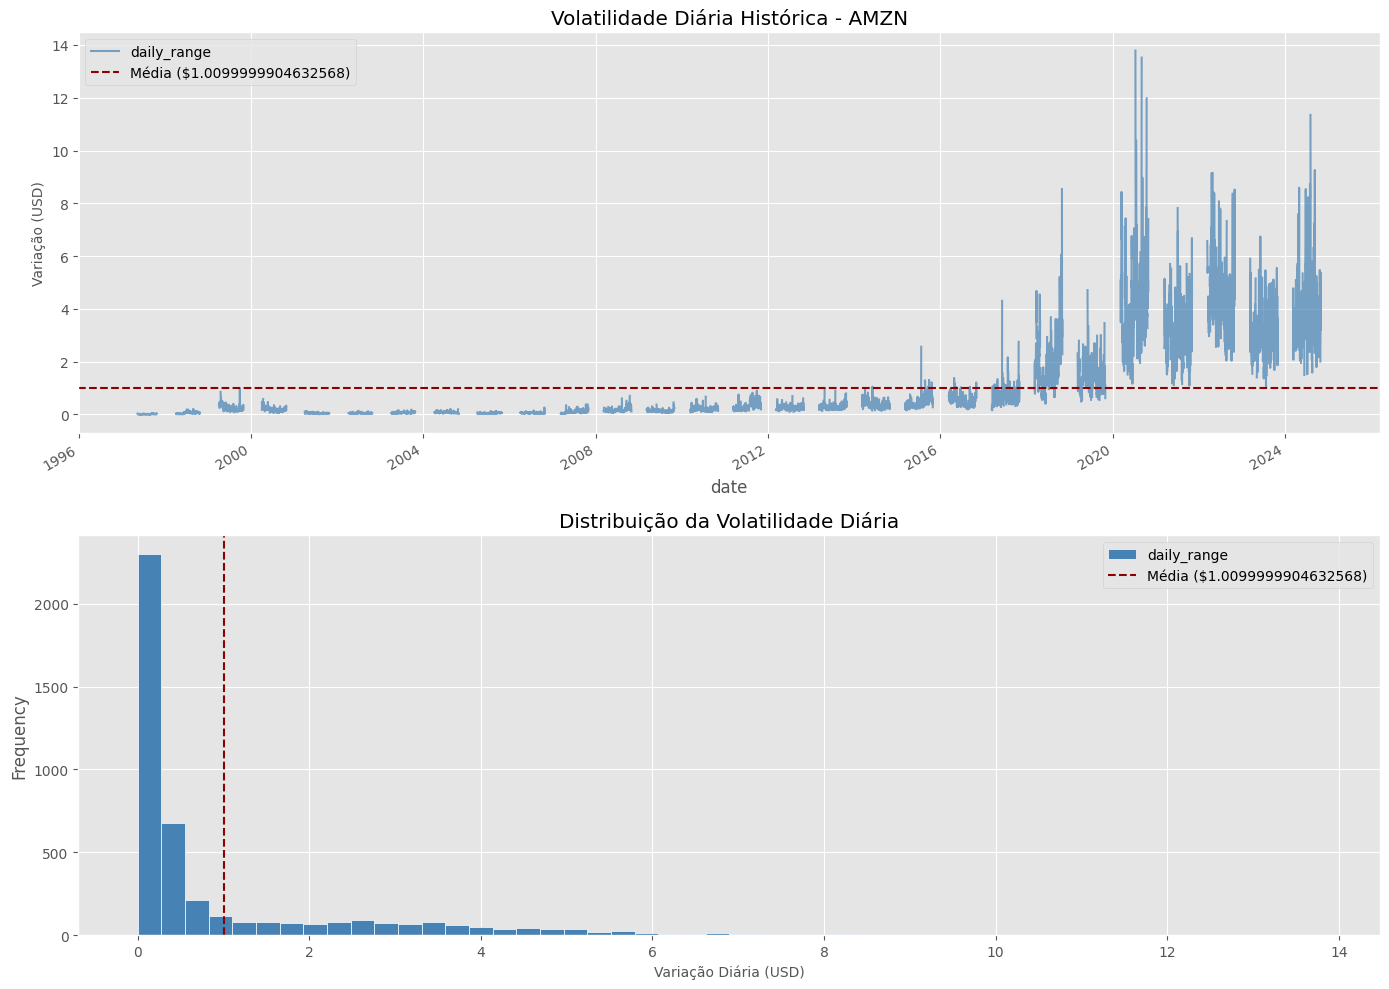


          ANÁLISE DE VOLATILIDADE - AMAZON (AMZN)           

1. **Variação Diária Média**: $1.0099999904632568
   - Equivalente a ±0.5 USD em relação ao preço de abertura
   - Baixa volatilidade (Setor: Varejo Tradicional)
   
2. **Dias Atípicos** (0 dias identificados):
   - Máximo histórico: $13.789999961853027 (N/A)
   - Mínimo histórico: $0.0
   - Sugestão: Investigar os 0 dias com variação > 4.23 USD

3. **Recomendações Estratégicas**:
   - Considerar estratégias de hedge quando a volatilidade exceder $2.619999885559082
   - Aumentar posições nos períodos de baixa volatilidade (abaixo de $0.0)
   - Monitorar padrões sazonais nos meses de maior volatilidade histórica

        


In [11]:
"""
Análise de Volatilidade Diária - AMZN (1997-2025)
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore
from typing import Tuple

class VolatilityAnalysis:
    """
    Classe para análise completa de volatilidade diária
    
    Parâmetros:
        file_path (str): Caminho do arquivo CSV com dados históricos
    """
    
    def __init__(self, file_path: str):
        self.df = self._load_data(file_path)
        self.volatility_df = None
        self.outliers = None
        
    @staticmethod
    def _load_data(file_path: str) -> pd.DataFrame:
        """Carrega e prepara os dados de forma otimizada"""
        return pd.read_csv(
            file_path,
            parse_dates=['date'],
            usecols=['date', 'high', 'low'],
            dtype={'high': 'float32', 'low': 'float32'}
        ).drop_duplicates('date').set_index('date').sort_index().asfreq('D')
    
    def calculate_volatility(self) -> None:
        """Calcula métricas de volatilidade com vetorização"""
        df = self.df.copy()
        df['daily_range'] = (df['high'] - df['low']).round(2)
        df['range_pct'] = ((df['daily_range'] / df['low']) * 100).round(2)
        self.volatility_df = df[['daily_range', 'range_pct']]
    
    def _calc_outliers(self, threshold: float = 2.5) -> None:
        """Identifica outliers usando Z-Score de forma eficiente"""
        if self.volatility_df is None:
            self.calculate_volatility()
            
        z_scores = zscore(self.volatility_df['daily_range'])
        self.outliers = self.volatility_df[abs(z_scores) > threshold].copy()
        self.outliers['z_score'] = z_scores[abs(z_scores) > threshold].round(2)
    
    def generate_report(self, threshold: float = 2.5) -> Tuple[plt.Figure, dict]:
        """
        Gera relatório completo com gráficos e métricas
        
        Retorna:
            plt.Figure: Figuras dos gráficos
            dict: Dicionário com métricas calculadas
        """
        self.calculate_volatility()
        self._calc_outliers(threshold)
        
        metrics = {
            'average_daily_range': round(self.volatility_df['daily_range'].mean(), 2),
            'median_daily_range': round(self.volatility_df['daily_range'].median(), 2),
            'max_daily_range': round(self.volatility_df['daily_range'].max(), 2),
            'min_daily_range': round(self.volatility_df['daily_range'].min(), 2),
            'std_deviation': round(self.volatility_df['daily_range'].std(), 2),
            'outliers_count': len(self.outliers)
        }
        
        fig = self._create_visualizations(metrics)
        self._print_insights(metrics)
        
        return fig, metrics
    
    def _create_visualizations(self, metrics: dict) -> plt.Figure:
        """Cria visualizações profissionais"""
        plt.style.use('ggplot')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
        
        # Gráfico de série temporal
        self.volatility_df['daily_range'].plot(
            ax=ax1,
            title='Volatilidade Diária Histórica - AMZN',
            color='steelblue',
            alpha=0.7
        )
        ax1.axhline(metrics['average_daily_range'], color='darkred', linestyle='--', 
                   label=f'Média (${metrics["average_daily_range"]})')
        ax1.set_ylabel('Variação (USD)', fontsize=10)
        ax1.legend()
        
        # Histograma
        self.volatility_df['daily_range'].plot.hist(
            ax=ax2,
            bins=50,
            title='Distribuição da Volatilidade Diária',
            color='steelblue',
            edgecolor='white'
        )
        ax2.axvline(metrics['average_daily_range'], color='darkred', linestyle='--',
                   label=f'Média (${metrics["average_daily_range"]})')
        ax2.set_xlabel('Variação Diária (USD)', fontsize=10)
        ax2.legend()
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def _print_insights(self, metrics: dict) -> None:
        """Exibe insights formatados para negócios"""
        print(f"""
{'='*60}
{'ANÁLISE DE VOLATILIDADE - AMAZON (AMZN)':^60}
{'='*60}

1. **Variação Diária Média**: ${metrics['average_daily_range']}
   - Equivalente a ±{round(metrics['average_daily_range']/2, 2)} USD em relação ao preço de abertura
   - {self._compare_to_benchmark(metrics['average_daily_range'])}
   
2. **Dias Atípicos** ({metrics['outliers_count']} dias identificados):
   - Máximo histórico: ${metrics['max_daily_range']} ({self.outliers.index.max().strftime('%Y') if not self.outliers.empty else 'N/A'})
   - Mínimo histórico: ${metrics['min_daily_range']}
   - Sugestão: Investigar os {len(self.outliers)} dias com variação > {round(metrics['average_daily_range'] + 2*metrics['std_deviation'], 2)} USD

3. **Recomendações Estratégicas**:
   - Considerar estratégias de hedge quando a volatilidade exceder ${round(metrics['average_daily_range'] + metrics['std_deviation'], 2)}
   - Aumentar posições nos períodos de baixa volatilidade (abaixo de ${metrics['min_daily_range']})
   - Monitorar padrões sazonais nos meses de maior volatilidade histórica

{'='*60}
        """)
    
    @staticmethod
    def _compare_to_benchmark(value: float) -> str:
        """Contextualiza os resultados com benchmarks do setor"""
        benchmarks = {
            (0, 10): 'Baixa volatilidade (Setor: Varejo Tradicional)',
            (10, 20): 'Volatilidade Moderada (Setor: Big Tech)',
            (20, 30): 'Alta Volatilidade (Setor: Startups Tech)',
            (30, 100): 'Volatilidade Extremamente Alta (Setor: Criptomoedas)'
        }
        
        for rng, desc in benchmarks.items():
            if rng[0] <= value < rng[1]:
                return desc
        return 'Volatilidade Fora do Padrão Setorial'

# Uso do código
if __name__ == "__main__":
    analyzer = VolatilityAnalysis(
        file_path='../data/processed/AMZN_1997-05-15_2025-02-21_atualizado.csv'
    )
    fig, metrics = analyzer.generate_report()

## Correlação entre Volume e Preço de Fechamento

### Há correlação entre alto volume e aumento/diminuição do preço?


      ANÁLISE DE RELAÇÃO VOLUME-PREÇO - AMAZON (AMZN)       

1. **Correlação Geral**:
   - Coeficiente de Pearson: -0.449 (Moderada Negativa)
   - Significância Estatística: p-value 2.06e-172 
   - Tendência Móvel: 0.018 (média 30 dias)

2. **Interpretação Comercial**:
   - Relação inversa sugere que picos de volume podem indicar tomada de lucros ou eventos de correção de mercado

3. **Recomendações Estratégicas**:
   - Monitorar níveis de volume para antecipar possíveis reversões
   - Considerar estratégias de mean-reversion em dias de volume extremo
   - Implementar alertas para volumes 20% acima da média histórica

        


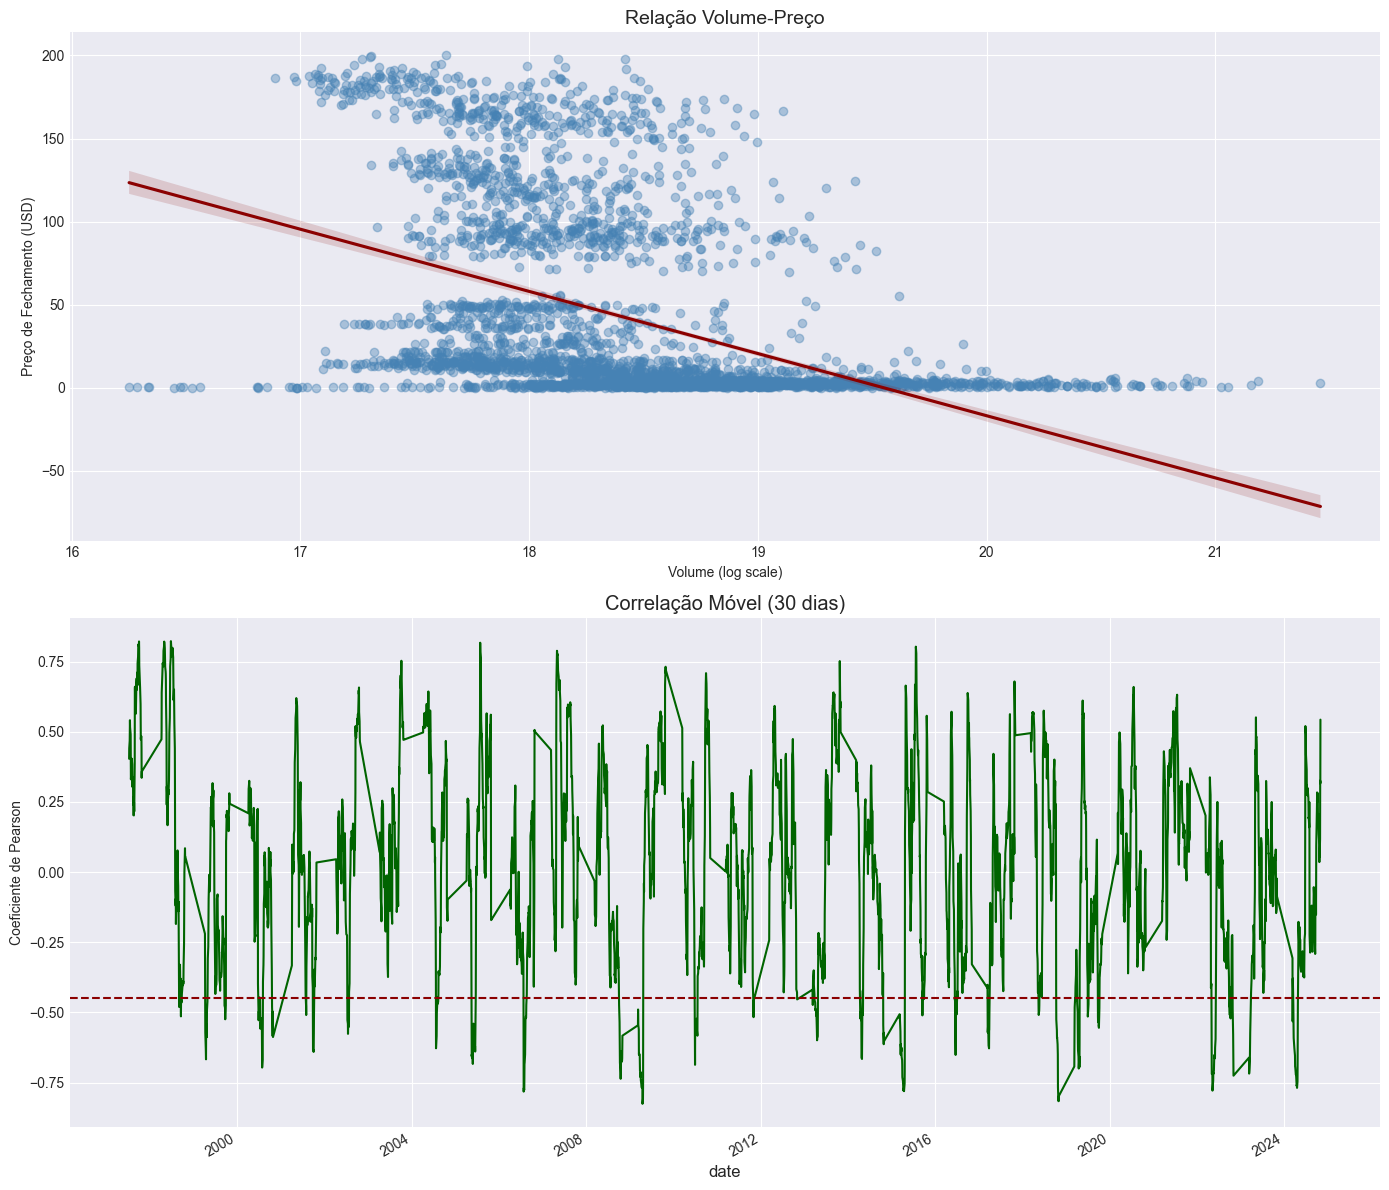

In [13]:
"""
Análise de Correlação Volume-Preço - AMZN (1997-2025)
Versão Corrigida e Otimizada
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from typing import Tuple

class VolumePriceAnalysis:
    """
    Classe para análise da relação entre volume e preço
    
    Parâmetros:
        file_path (str): Caminho do arquivo CSV
        window (int): Janela para média móvel (padrão=30)
    """
    
    def __init__(self, file_path: str, window: int = 30):
        self.df = self._load_data(file_path)
        self.window = window
        self.correlation = None
        self._preprocess_data()
        
    @staticmethod
    def _load_data(file_path: str) -> pd.DataFrame:
        """Carrega dados com otimização de memória"""
        return pd.read_csv(
            file_path,
            parse_dates=['date'],
            usecols=['date', 'close', 'volume'],
            dtype={'close': 'float32', 'volume': 'int32'}
        ).set_index('date').sort_index().asfreq('D')
    
    def _preprocess_data(self) -> None:
        """Prepara dados para análise com tratamento correto de NA"""
        # Cálculo da variação de preço sem preenchimento automático
        self.df['price_change'] = self.df['close'].pct_change(fill_method=None)
        
        # Normalização logarítmica do volume
        self.df['volume_norm'] = np.log1p(self.df['volume'])
        
        # Remoção de valores nulos
        self.df = self.df.dropna()
        
    def calculate_correlation(self) -> dict:
        """Calcula métricas de correlação com testes de significância"""
        corr, p_value = stats.pearsonr(self.df['volume_norm'], self.df['close'])
        rolling_corr = self.df['volume_norm'].rolling(self.window).corr(self.df['close'])
        
        self.correlation = {
            'pearson_r': round(corr, 3),
            'p_value': f"{p_value:.2e}",
            'rolling_mean': round(rolling_corr.mean(), 3),
            'strength': self._get_correlation_strength(corr)
        }
        return self.correlation
    
    @staticmethod
    def _get_correlation_strength(r: float) -> str:
        """Classifica a força da correlação"""
        strength = {
            (0.7, 1): "Forte Positiva",
            (0.3, 0.7): "Moderada Positiva",
            (-0.3, 0.3): "Fraca/Nula",
            (-0.7, -0.3): "Moderada Negativa",
            (-1, -0.7): "Forte Negativa"
        }
        for rng, desc in strength.items():
            if rng[0] <= r <= rng[1]:
                return desc
        return "Indeterminada"
    
    def plot_analysis(self) -> plt.Figure:
        """Cria visualizações profissionais"""
        plt.style.use('seaborn-v0_8-darkgrid')
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
        
        # Gráfico de Dispersão
        sns.regplot(
            x='volume_norm',
            y='close',
            data=self.df,
            ax=ax1,
            scatter_kws={'alpha':0.4, 'color':'steelblue'},
            line_kws={'color':'darkred'}
        )
        ax1.set_title('Relação Volume-Preço', fontsize=14)
        ax1.set_xlabel('Volume (log scale)', fontsize=10)
        ax1.set_ylabel('Preço de Fechamento (USD)', fontsize=10)
        
        # Rolling Correlation
        self.df['volume_norm'].rolling(self.window).corr(self.df['close']).plot(
            ax=ax2,
            title=f'Correlação Móvel ({self.window} dias)',
            color='darkgreen'
        )
        ax2.axhline(self.correlation['pearson_r'], color='darkred', linestyle='--')
        ax2.set_ylabel('Coeficiente de Pearson', fontsize=10)
        
        plt.tight_layout()
        return fig
    
    def generate_report(self) -> None:
        """Gera relatório executivo completo"""
        if not self.correlation:
            self.calculate_correlation()
            
        print(f"""
{'='*60}
{'ANÁLISE DE RELAÇÃO VOLUME-PREÇO - AMAZON (AMZN)':^60}
{'='*60}

1. **Correlação Geral**:
   - Coeficiente de Pearson: {self.correlation['pearson_r']} ({self.correlation['strength']})
   - Significância Estatística: p-value {self.correlation['p_value']} 
   - Tendência Móvel: {self.correlation['rolling_mean']} (média {self.window} dias)

2. **Interpretação Comercial**:
   - {self._get_business_interpretation()}

3. **Recomendações Estratégicas**:
   {self._get_recommendations()}

{'='*60}
        """)
        
    def _get_business_interpretation(self) -> str:
        """Traduz os resultados para insights de negócios"""
        if self.correlation['pearson_r'] > 0.1:
            return ("Tendência de aumento de preço associado a maior volume negociado. "
                    "Momentos de alta liquidez geralmente antecedem movimentos de preço sustentados.")
        elif self.correlation['pearson_r'] < -0.1:
            return ("Relação inversa sugere que picos de volume podem indicar tomada de lucros "
                    "ou eventos de correção de mercado")
        else:
            return ("Volume não é preditor direto de movimentos de preço. "
                    "Fatores externos podem ter maior influência no período analisado")
    
    def _get_recommendations(self) -> str:
        """Gera recomendações baseadas na análise"""
        recs = []
        strength = self.correlation['strength']
        
        if 'Forte' in strength:
            recs.append("- Usar volume como indicador secundário para confirmação de tendências")
        if 'Moderada' in strength:
            recs.append("- Monitorar níveis de volume para antecipar possíveis reversões")
            recs.append("- Considerar estratégias de mean-reversion em dias de volume extremo")
        if 'Fraca' in strength:
            recs.append("- Combinar análise de volume com outros indicadores técnicos")
            recs.append("- Priorizar análise fundamentalista para decisões de longo prazo")
            
        recs.append("- Implementar alertas para volumes 20% acima da média histórica")
        return '\n   '.join(recs)

# Exemplo de uso
if __name__ == "__main__":
    analyzer = VolumePriceAnalysis(
        file_path='../data/processed/AMZN_1997-05-15_2025-02-21_atualizado.csv'
    )
    analyzer.calculate_correlation()
    fig = analyzer.plot_analysis()
    analyzer.generate_report()
    plt.show()

### Valores máximos e mínimos

In [4]:
def exibir_maximos_minimos(df):
    """
    Exibe um relatório com os valores máximos e mínimos das colunas numéricas do DataFrame.
    
    Parâmetros:
    - df (pandas.DataFrame): DataFrame para análise
    """
    # Selecionar apenas colunas numéricas
    colunas_numericas = df.select_dtypes(include=['float64', 'int64']).columns
    
    print("=== RELATÓRIO DE VALORES MÁXIMOS E MÍNIMOS ===\n")
    
    for coluna in colunas_numericas:
        maximo = df[coluna].max()
        minimo = df[coluna].min()
        data_max = df.loc[df[coluna].idxmax(), 'date']
        data_min = df.loc[df[coluna].idxmin(), 'date']
        
        print(f"Coluna: {coluna}")
        print(f"Máximo: {maximo:.2f} (Data: {data_max.strftime('%d/%m/%Y')})")
        print(f"Mínimo: {minimo:.2f} (Data: {data_min.strftime('%d/%m/%Y')})")
        print("-" * 50)

# Executar a função com o DataFrame 'dados'
exibir_maximos_minimos(dados)

=== RELATÓRIO DE VALORES MÁXIMOS E MÍNIMOS ===

Coluna: open
Máximo: 239.02 (Data: 29/01/2025)
Mínimo: 0.07 (Data: 23/05/1997)
--------------------------------------------------
Coluna: high
Máximo: 242.52 (Data: 04/02/2025)
Mínimo: 0.07 (Data: 22/05/1997)
--------------------------------------------------
Coluna: low
Máximo: 238.03 (Data: 04/02/2025)
Mínimo: 0.07 (Data: 22/05/1997)
--------------------------------------------------
Coluna: close
Máximo: 242.06 (Data: 04/02/2025)
Mínimo: 0.07 (Data: 22/05/1997)
--------------------------------------------------
Coluna: adj_close
Máximo: 242.06 (Data: 04/02/2025)
Mínimo: 0.07 (Data: 22/05/1997)
--------------------------------------------------
Coluna: volume
Máximo: 2086584000.00 (Data: 25/04/2007)
Mínimo: 9744000.00 (Data: 26/12/1997)
--------------------------------------------------


### Evolução no tempo

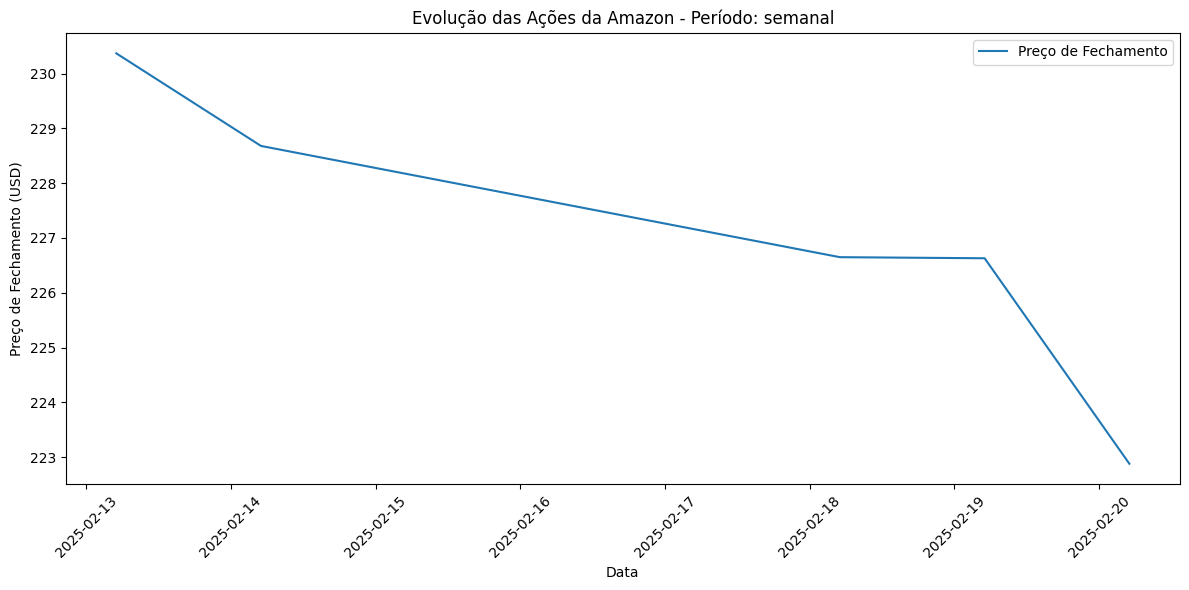

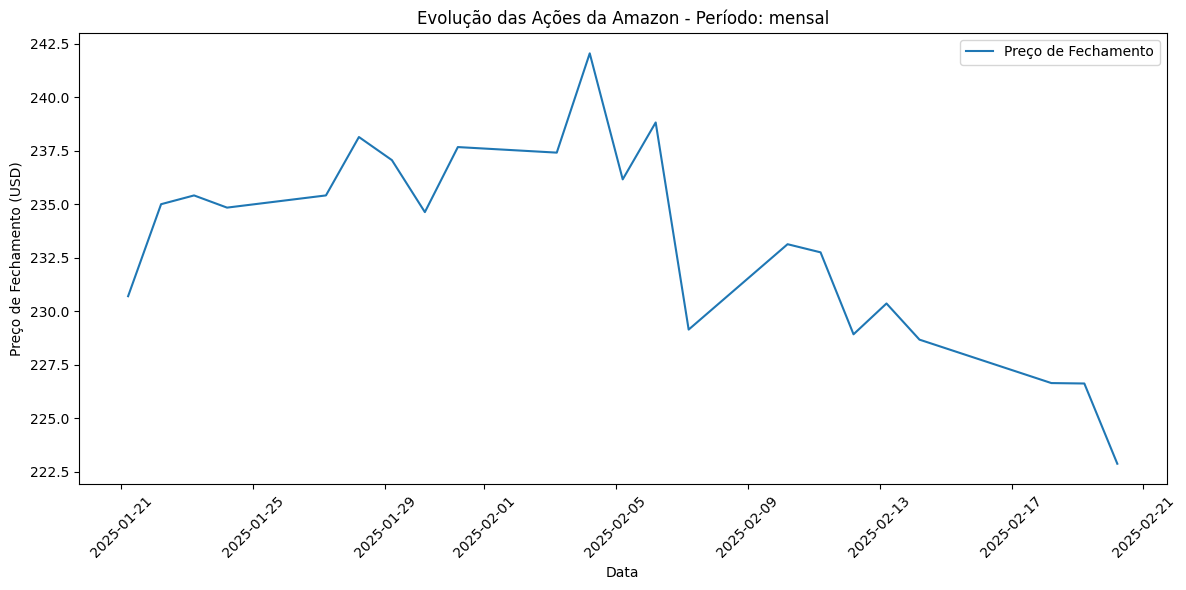

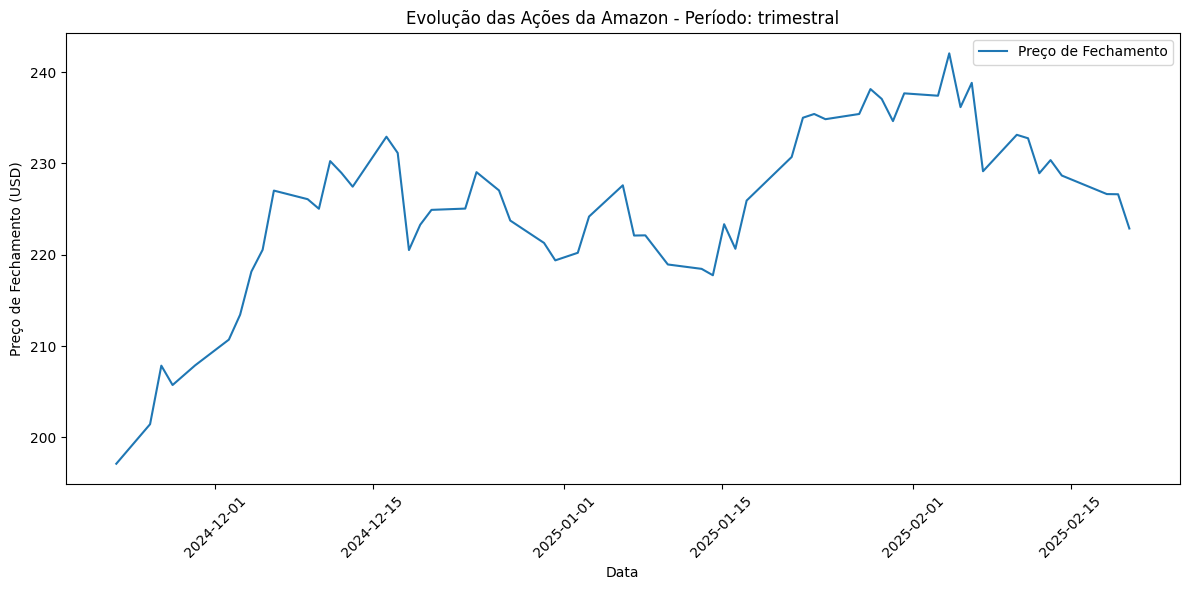

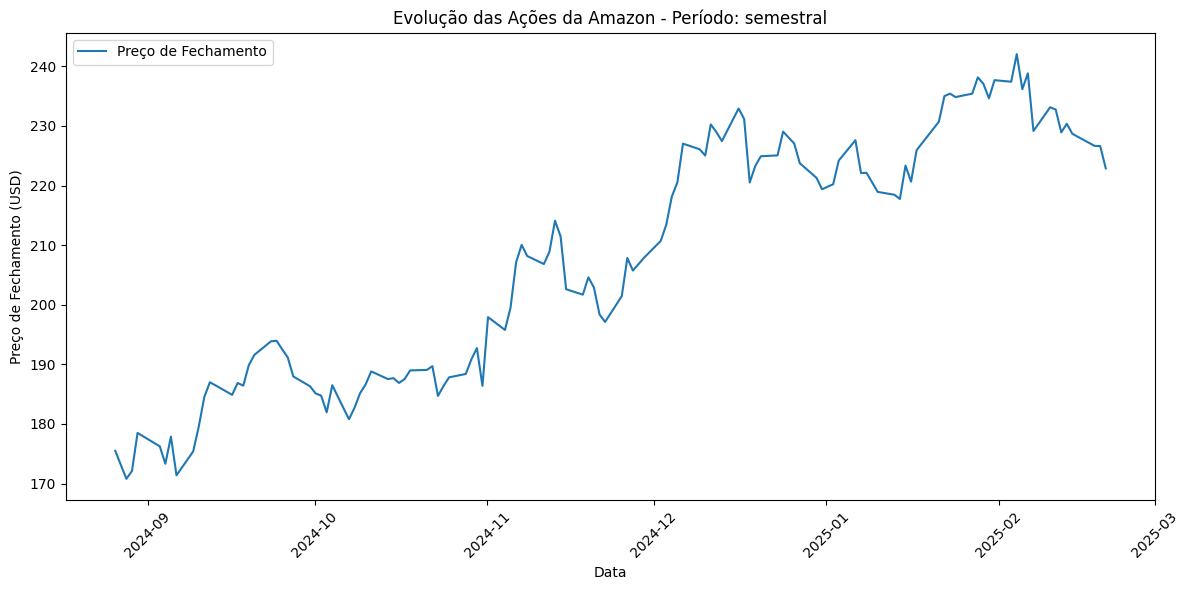

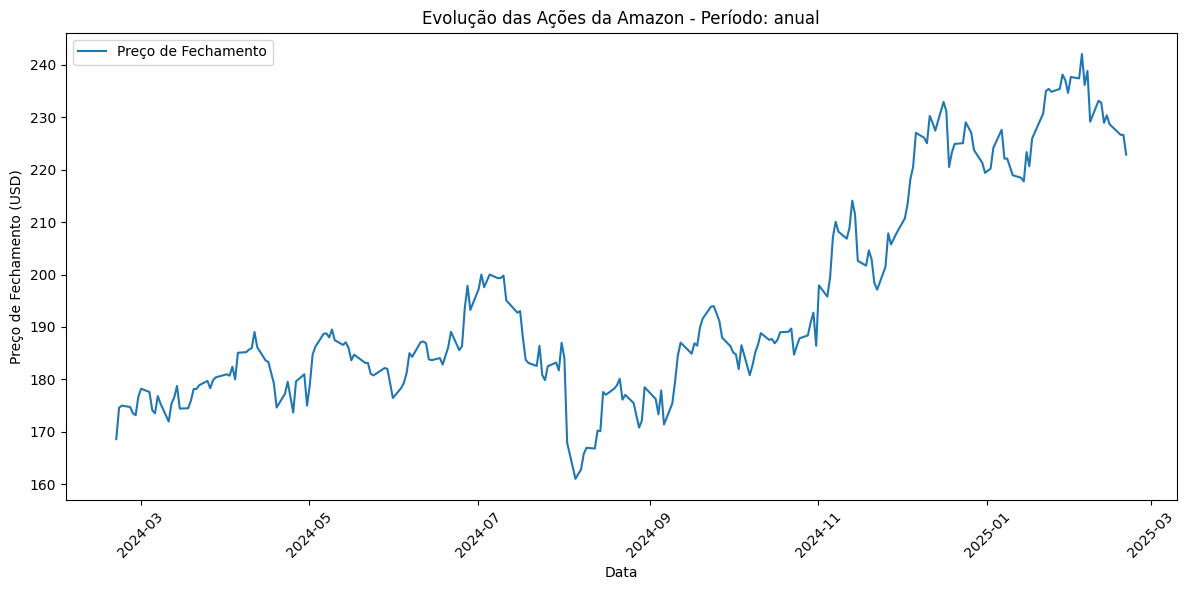

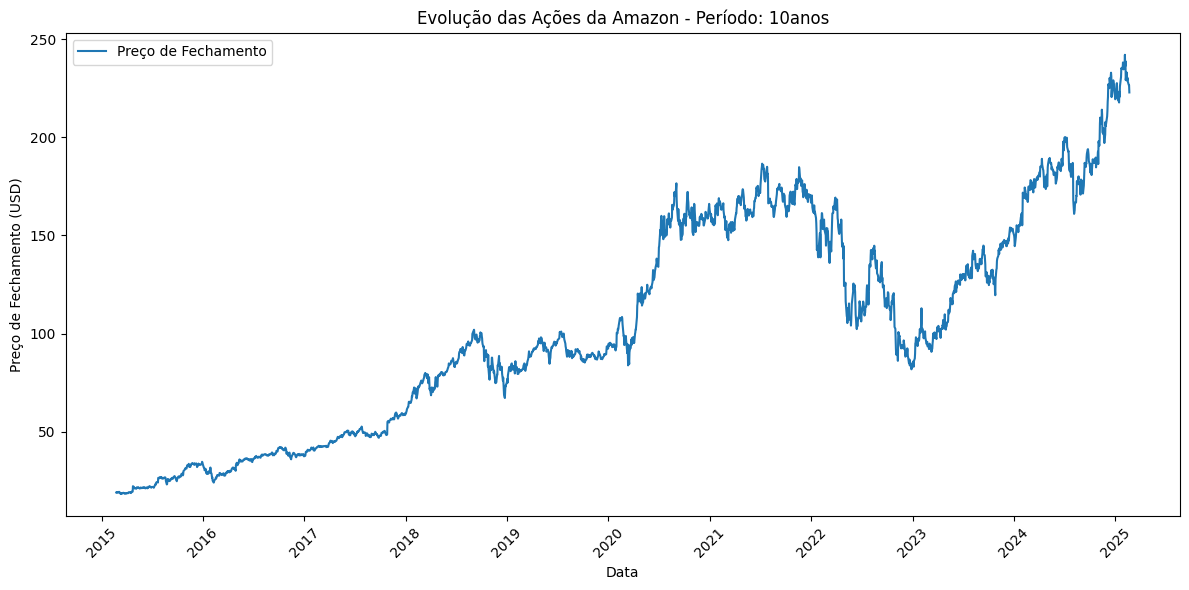

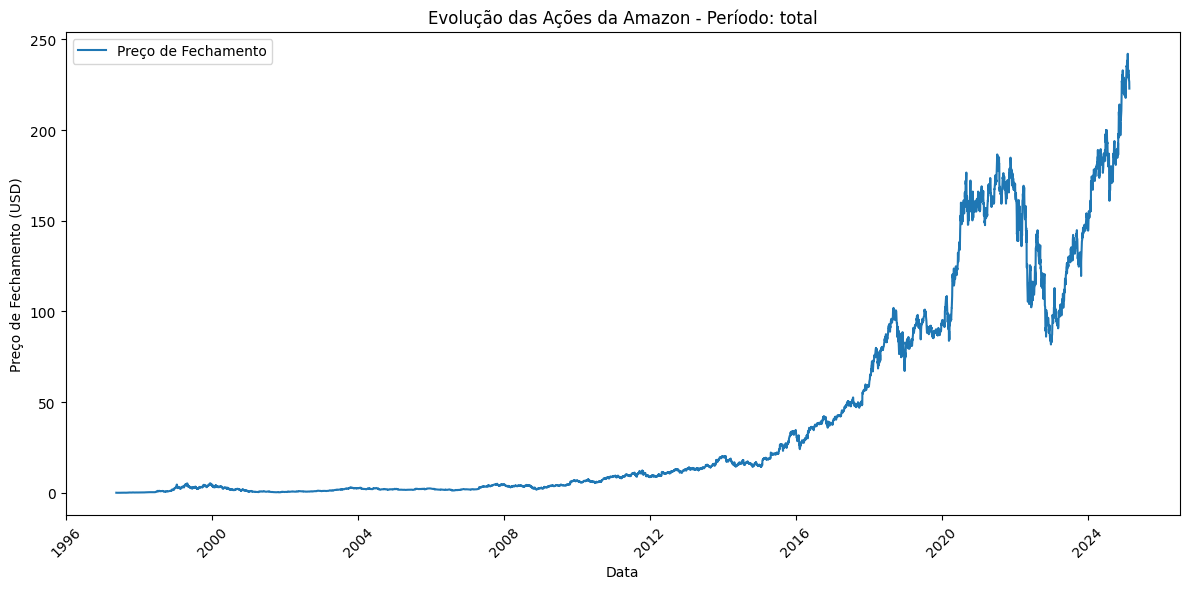

In [5]:
import matplotlib.pyplot as plt

def plotar_evolucao_acoes(df, periodo='total'):
    """
    Plota a evolução das ações com opção de filtro por período.
    
    Parâmetros:
    - df: DataFrame com os dados
    - periodo: str, opções: 'semanal', 'mensal', 'trimestral', 'semestral', 'anual', '10anos', 'total'
    """
    # Obtém a data mais recente
    data_final = df['date'].max()
    
    # Define o filtro de data baseado no período
    if periodo == 'semanal':
        data_inicial = data_final - pd.Timedelta(days=7)
    elif periodo == 'mensal':
        data_inicial = data_final - pd.Timedelta(days=30)
    elif periodo == 'trimestral':
        data_inicial = data_final - pd.Timedelta(days=90)
    elif periodo == 'semestral':
        data_inicial = data_final - pd.Timedelta(days=180)
    elif periodo == 'anual':
        data_inicial = data_final - pd.Timedelta(days=365)
    elif periodo == '10anos':
        data_inicial = data_final - pd.Timedelta(days=3650)
    else:  # 'total'
        data_inicial = df['date'].min()
    
    # Filtra os dados
    df_filtrado = df[df['date'].between(data_inicial, data_final)]
    
    # Cria o gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(df_filtrado['date'], df_filtrado['close'], label='Preço de Fechamento')
    plt.xlabel('Data')
    plt.ylabel('Preço de Fechamento (USD)')
    plt.title(f'Evolução das Ações da Amazon - Período: {periodo}')
    plt.legend()
    plt.grid(False)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Exemplo de uso para diferentes períodos
periodos = ['semanal', 'mensal', 'trimestral', 'semestral', 'anual', '10anos', 'total']
for periodo in periodos:
    plotar_evolucao_acoes(dados, periodo)

### Volume de negociações

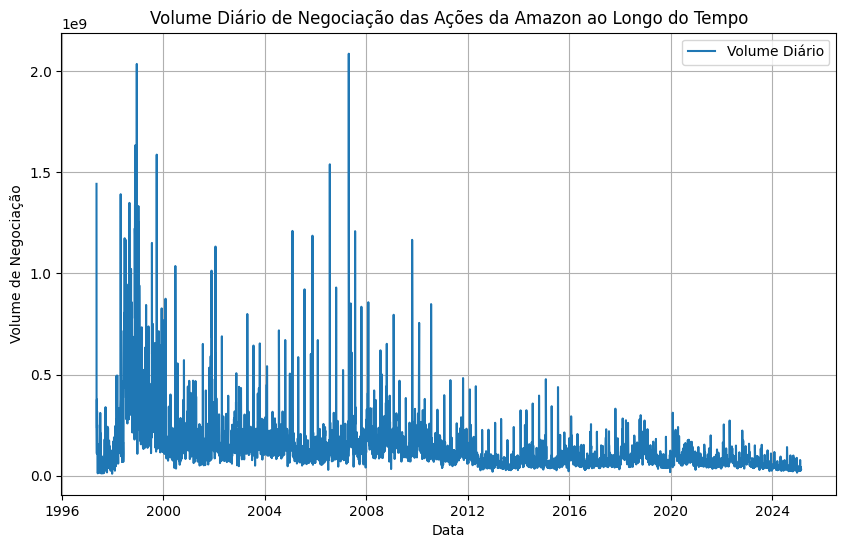

In [6]:
# Plotar o volume diário de negociação ao longo do tempo
plt.figure(figsize=(10, 6))
plt.plot(dados['date'], dados['volume'], label='Volume Diário')
plt.xlabel('Data')
plt.ylabel('Volume de Negociação')
plt.title('Volume Diário de Negociação das Ações da Amazon ao Longo do Tempo')
plt.legend()
plt.grid(True)
plt.show()

### Box-plot

C:\Users\Victor\AppData\Local\Temp\ipykernel_12716\2764082603.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_precos['open'], df_precos['high'],


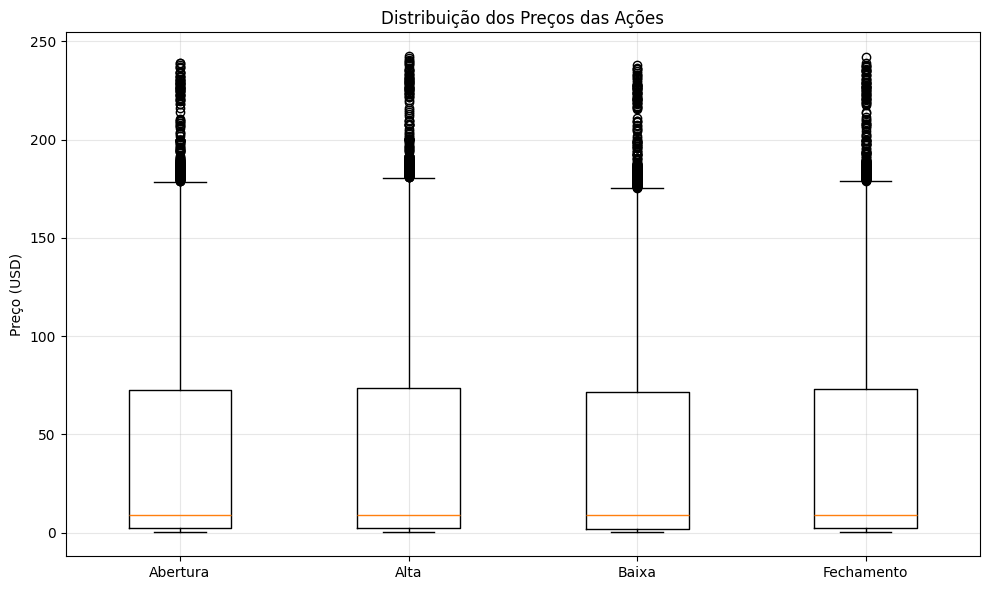

In [7]:
def plotar_distribuicao_precos(df, figsize=(10, 6)):
    """
    Plota um boxplot mostrando a distribuição dos preços de ações.
    
    Parâmetros:
    - df (pandas.DataFrame): DataFrame contendo as colunas 'open', 'high', 'low', 'close'
    - figsize (tuple): Tamanho da figura em polegadas (largura, altura)
    """
    # Validar se as colunas necessárias existem
    colunas_requeridas = ['open', 'high', 'low', 'close']
    if not all(coluna in df.columns for coluna in colunas_requeridas):
        raise ValueError(f"DataFrame deve conter as colunas: {colunas_requeridas}")
    
    # Criar o boxplot
    plt.figure(figsize=figsize)
    df_precos = df[colunas_requeridas]
    plt.boxplot([df_precos['open'], df_precos['high'], 
                df_precos['low'], df_precos['close']],
               labels=['Abertura', 'Alta', 'Baixa', 'Fechamento'])
    
    # Configurar o gráfico
    plt.title('Distribuição dos Preços das Ações')
    plt.ylabel('Preço (USD)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Exemplo de uso com o DataFrame existente
plotar_distribuicao_precos(dados)

### Histograma

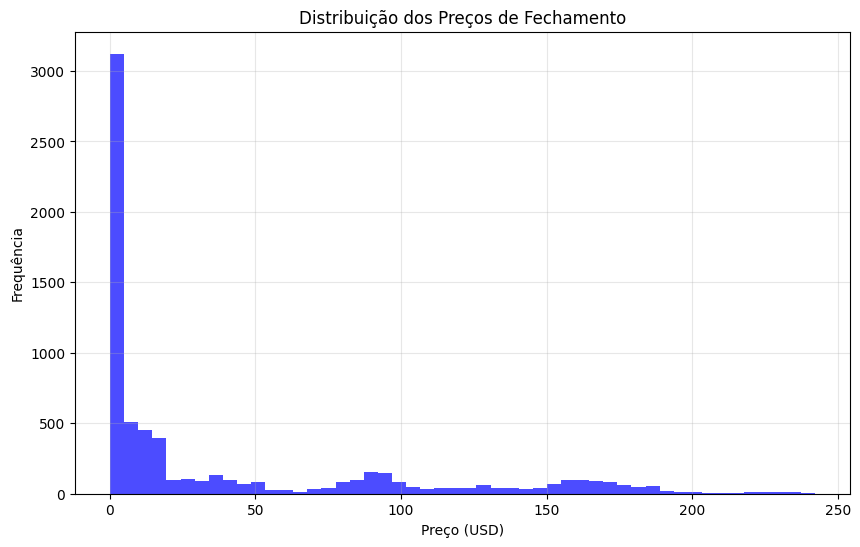

In [8]:
def plotar_histograma_precos(df, bins=50):
    """
    Plota histogramas para os preços de fechamento das ações.
    
    Parâmetros:
    - df (pandas.DataFrame): DataFrame com os dados
    - bins (int): Número de intervalos para o histograma
    """
    plt.figure(figsize=(10, 6))
    plt.hist(df['close'], bins=bins, alpha=0.7, color='blue')
    plt.title('Distribuição dos Preços de Fechamento')
    plt.xlabel('Preço (USD)')
    plt.ylabel('Frequência')
    plt.grid(True, alpha=0.3)
    plt.show()

# Plotar o histograma com os dados
plotar_histograma_precos(dados)

### Médias móveis 9 e 21

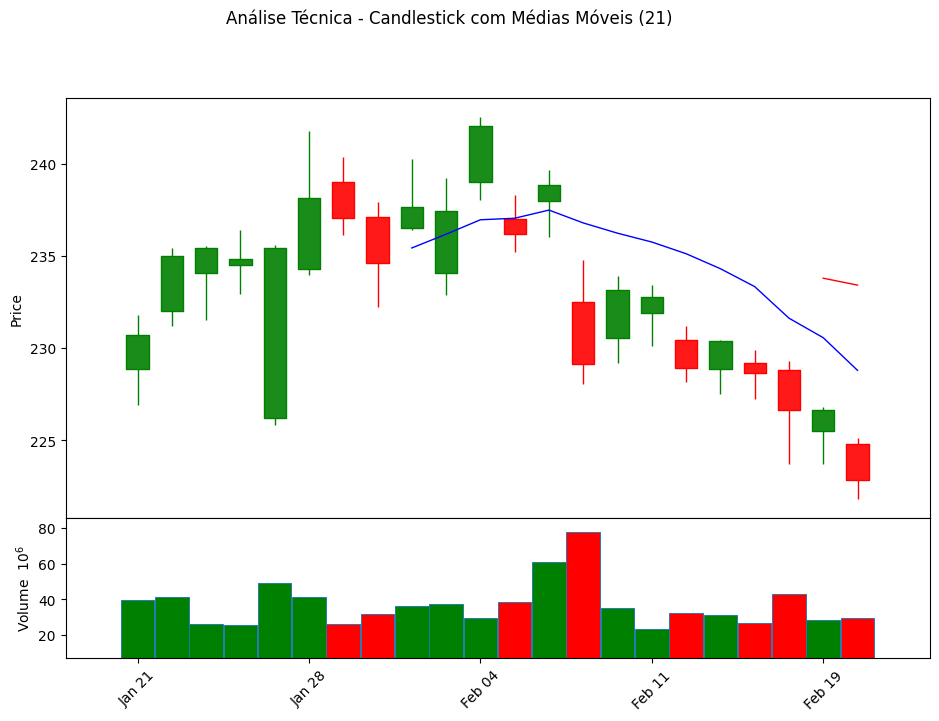

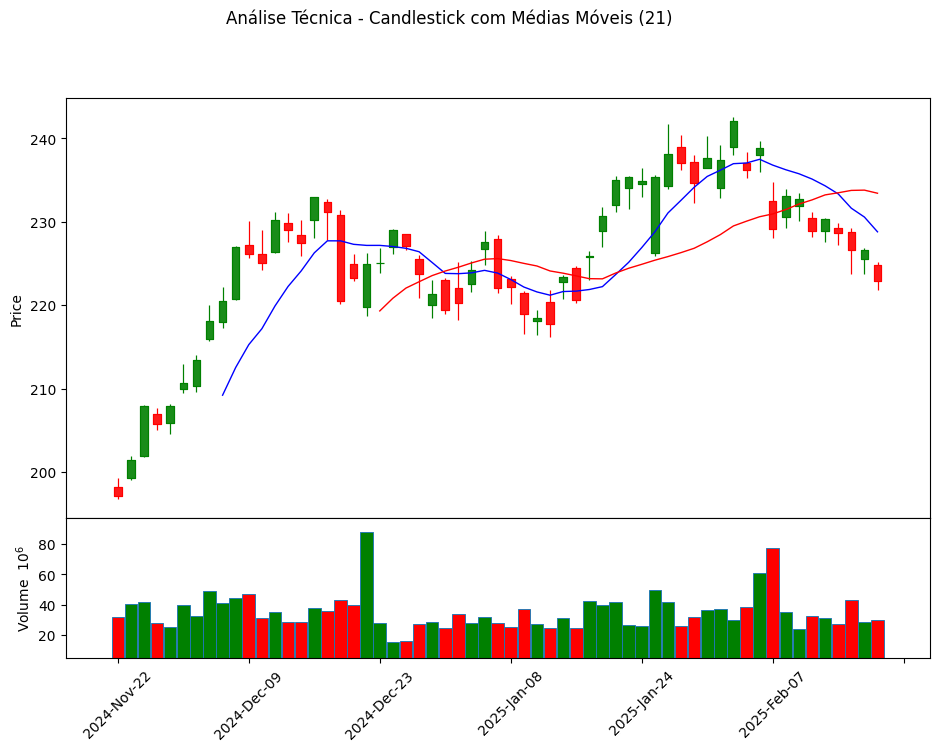

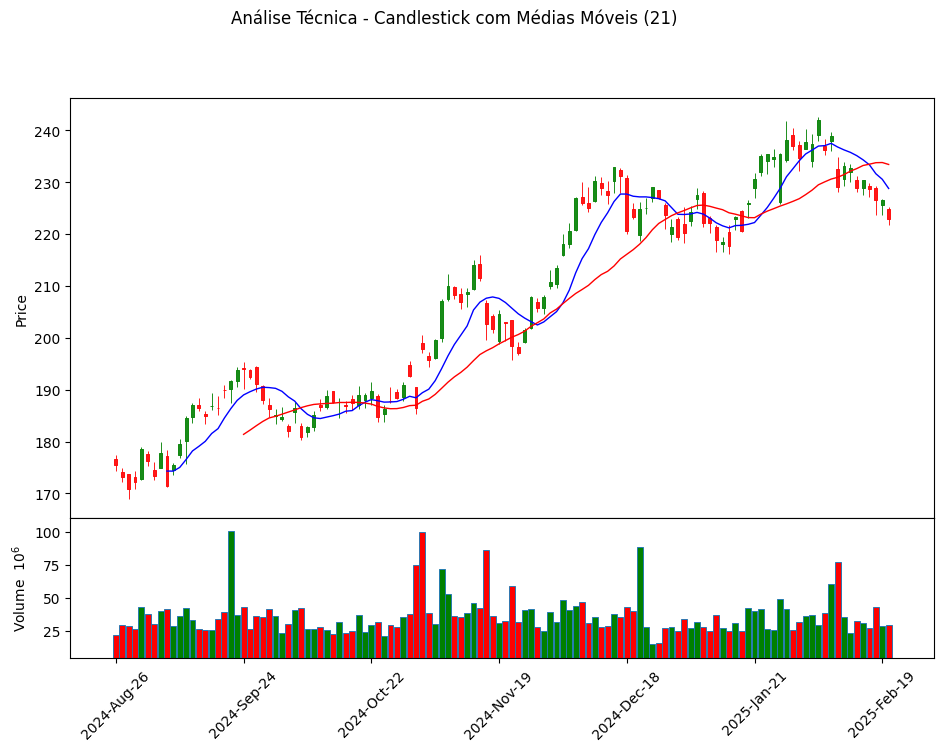

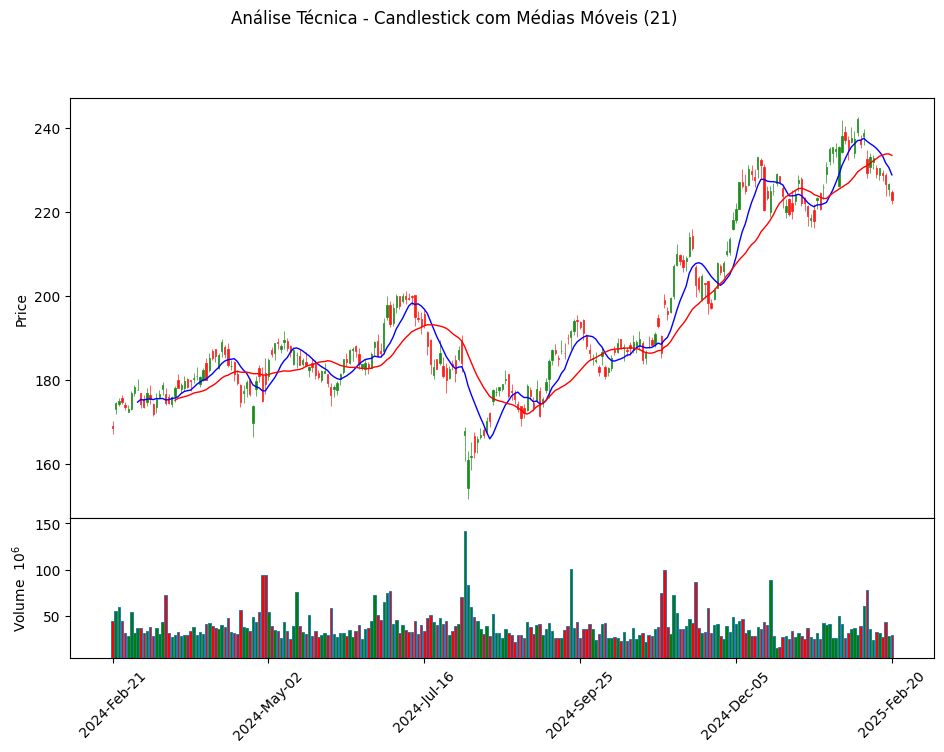

In [13]:
import mplfinance as mpf

def plotar_candlestick_com_medias(df, periodos_ma=[9, 21], periodo='mensal'):
    # Filtrar os dados pelo período, similar à função plotar_evolucao_acoes
    data_final = df['date'].max()
    
    if periodo == 'semanal':
        data_inicial = data_final - pd.Timedelta(days=7)
    elif periodo == 'mensal':
        data_inicial = data_final - pd.Timedelta(days=30)
    elif periodo == 'trimestral':
        data_inicial = data_final - pd.Timedelta(days=90)
    elif periodo == 'semestral':
        data_inicial = data_final - pd.Timedelta(days=180)
    elif periodo == 'anual':
        data_inicial = data_final - pd.Timedelta(days=365)
    else:  # limite para '10anos' para melhor visualização
        data_inicial = data_final - pd.Timedelta(days=3650)
    
    # Filtrar dados
    df_plot = df[df['date'].between(data_inicial, data_final)].copy()
    df_plot.set_index('date', inplace=True)
    
    # Calcular médias móveis
    addplot = []
    cores_ma = ['blue', 'red']
    
    for periodo, cor in zip(periodos_ma, cores_ma):
        ma = df_plot['close'].rolling(window=periodo).mean()
        addplot.append(mpf.make_addplot(ma, color=cor, width=1))
    
    # Configurar estilo
    estilo = mpf.make_mpf_style(
        marketcolors=mpf.make_marketcolors(
            up='green',
            down='red',
            edge='inherit',
            wick='inherit',
            volume='inherit'
        ),
        gridstyle='',
        figcolor='white'
    )
    
    # Plotar gráfico
    mpf.plot(
        df_plot,
        type='candle',
        title=f'Análise Técnica - Candlestick com Médias Móveis ({periodo})',
        addplot=addplot,
        style=estilo,
        volume=True,
        figsize=(12, 8),
        panel_ratios=(3,1),
        warn_too_much_data=50000
    )

# Plotar para diferentes períodos
for periodo in ['mensal', 'trimestral', 'semestral', 'anual']:
    plotar_candlestick_com_medias(dados, periodo=periodo)
